# 411.069 Special Topics Data Handling and Programming in Climate Science – netCDF & xarray
Florian Ladstädter

# Data formats

- Text – __ASCII__ – __CSV__ (comma-separated values)
- Text – __YAML__ (YAML Ain't Markup Language): Human-readable data-serialization language, often used for configuration files
- Binary – __netCDF4__ (network common data format): Scientific, geospatial, climate, meteorological data
- Binary – __HDF5__ (hierarchical data format)
- Binary – __GRIB__ (Gridded Binary): Meteorological data

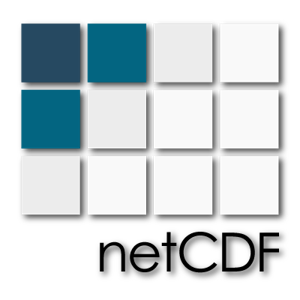

In [1]:
from IPython.display import display
from PIL import Image

img = Image.open("figs/netcdf-400x400_unidata.png")
img = img.resize((300, 300))
display(img)

# __netCDF__

- Self-describing data format for multiple dimensions.
- One of the most commonly used file format for climate/meteorological/geophysical and other scientific data.
- netCDF is an _open standard_, created and maintained by UCAR (University Corporation for Atmospheric Research).
- Data in netCDF is _self-describing_, i.e. it contains the data _and_ metadata to describe the content.

- _Binary format_, need specific tools to interpret the file.
- Quick look from the command line:
```bash
ncdump -h <file>
ncdump <file> | less
```
- To use `ncdump`: Install netcdf-bin system-wide: `sudo apt install netcdf-bin`.
- Interfaces to many programming languages, e.g. Python (`netcdf4-python`).
- Recommended usage in Python with: __`xarray`__
- For netCDF files containing tabular data: Could convert to pandas dataframe (if preferred):
```python
df = ds.to_dataframe()
```
- Otherwise: Stay with `xarray`: https://xarray.pydata.org/en/stable/user-guide/.

### netCDF example: ERA5 from Copernicus
- Download from: https://cds.climate.copernicus.eu
- E.g. monthly averaged 2-m temperature for Jan/Jul 2020.

In [ ]:
!ncdump -h /home/fhl/work/LVs/data/era5_monthly_t2m_2020_Jan_Jul.nc

In [ ]:
fn = "~/work/LVs/data/era5_monthly_t2m_2020_Jan_Jul.nc"

In [ ]:
# Read file with xarray
import xarray as xr

ds = xr.open_dataset(fn)

In [ ]:
ds

In [ ]:
ds.info()

---

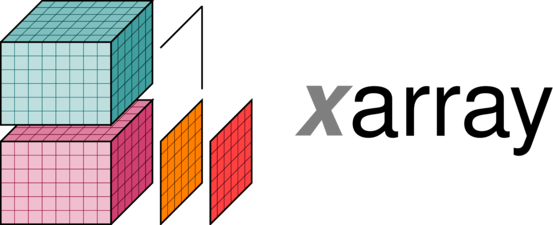

In [2]:
from IPython.display import display
from PIL import Image

img = Image.open("figs/xarray-dataset-diagram-logo.png")
# img = img.resize((300, 300))
display(img)

# __xarray__

## Create an xarray `DataArray`

In [ ]:
import numpy as np

t = np.array([[280.1, 275.5, 268.5], [290.2, 291.1, 288.7]])
t.mean(axis=1)

In [ ]:
import xarray as xr

da = xr.DataArray(
    t, dims=("lon", "lat"), coords={"lat": [45.0, 50.0, 55.0], "lon": [100.0, 110.0]}
)
da

### It contains dimensions, coords, and values 

In [ ]:
da.dims

In [ ]:
da.coords

In [ ]:
da.values

### Apply operations over dimensions by name

In [ ]:
da.mean(dim="lat")

In [ ]:
da.sel(lat=50)

### Alignment by dimension name and coord values

In [ ]:
p = 100 * np.random.randn(2, 3) + 1000
da2 = xr.DataArray(
    p, dims=("lon", "lat"), coords={"lat": [50.0, 55.0, 60.0], "lon": [100.0, 110.0]}
)
da2

In [ ]:
da.coords

In [ ]:
da2.coords

In [ ]:
da + da2

## xarray `Dataset`

In [ ]:
ds = xr.Dataset({"temp": da, "pres": da2})
ds

In [ ]:
ds.dims

In [ ]:
ds.coords

In [ ]:
ds.data_vars

### Assign attributes

In [ ]:
ds["temp"].attrs

In [ ]:
ds["temp"].attrs["units"] = "K"
ds["pres"].attrs["units"] = "hPa"
ds["temp"]

In [ ]:
ds.attrs["source"] = "Institute xy"

In [ ]:
ds

### `Dataset` enables us to work with several variables at once

In [ ]:
# xarray keeps the attributes only when passing keep_attrs=True, or setting this option globally.
ds.mean(dim="lon", keep_attrs=True)

## Write to netCDF

In [ ]:
ds.to_netcdf("/tmp/data.nc")

In [ ]:
!ncdump -h /tmp/data.nc

## Open netCDF files

In [ ]:
ds = xr.open_dataset(
    "/home/fhl/work/LVs/data/ECMWF_IFS-ea-0051_an_F32-T42_yggdrasil-0.5.0_altitude_10x10_temperature.nc"
)

In [ ]:
ds

### Open files and be sure that dataset is completely in memory

In [ ]:
# this can be important for performance, or if you want to write data to the same file you have just opened.
# Use the context manager
fn = "/home/fhl/work/LVs/data/ECMWF_IFS-ea-0051_an_F32-T42_yggdrasil-0.5.0_altitude_10x10_temperature.nc"
with xr.open_dataset(fn) as ds:
    ds.load()

## Set keep_attrs globally

In [ ]:
xr.set_options(keep_attrs=True)

## Aggregating, selecting, plotting

In [ ]:
ds.temperature_2_meter.mean("longitude").sel(latitude=5).plot()

In [ ]:
ds.temperature.sel(latitude=5, altitude=20000).mean("longitude").plot()

### Mean over a sliced selection of coordinate values

In [ ]:
ds.temperature.sel(latitude=slice(70, 90), altitude=20000).mean(
    ["longitude", "latitude"]
).plot()

### groupby

In [ ]:
ds.sel(time=slice("1991-01-01", "2019-12-31"))

In [ ]:
ds.sel(time=slice("1991-01-01", "2019-12-31")).groupby("time.month")

In [ ]:
clim = ds.sel(time=slice("1991-01-01", "2019-12-31")).groupby("time.month").mean()
clim

In [ ]:
anom = ds.groupby("time.month") - clim
anom

In [ ]:
anom.temperature_2_meter.mean(["longitude", "latitude"]).plot()

In [ ]:
# plot on 2d maps
# if you use pip to install things, you might need the following to make cartopy work:
# pip uninstall shapely
# pip install shapely --no-binary shapely
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

anom_2m = anom.temperature_2_meter.sel(time="2020-01-01")

ax = plt.axes(projection=ccrs.EqualEarth())  # map projection
anom_2m.plot(
    ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6}
)  # plot 2m temp onto axis
# the keyword "transform" tells cartopy in which projection the data is stored
ax.coastlines()
ax.gridlines()  # Add gridlines and coastlines to the plot
plt.show()

## Access the actual NumPy arrays

In [ ]:
anom.temperature

In [ ]:
# use the .values attribute to access the numpy array directly, if needed.
anom.temperature_2_meter.values